## <u>*Regression Modelling for Severity as a Target Feature*</u>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from datetime import datetime,time
import os

In [65]:
df=pd.read_csv(r"C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/Data_Sets/new_cleaned_df.csv")

In [66]:
df.drop(["clm"],axis=1,inplace=True)

In [67]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,mean_absolute_error,accuracy_score,root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRFRegressor
import graphviz
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold
import warnings                                  
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tqdm import tqdm

---

*Date preprocessing*

In [68]:
categories_encoder=LabelEncoder()
for col in df:
    if col in list(df.select_dtypes(include="object").columns):
        df[col]=categories_encoder.fit_transform(df[col])

In [69]:
df=df[df["claimcst0"]>0]
df.head()

,veh_value,exposure,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat,severity,frequincy,pure_premium
14,1660.0,0.484600,1,669.509999,9,3,1,1,6,670.0,2.063559,1381.573600
16,1510.0,0.993840,1,806.609999,9,3,0,5,4,807.0,1.006198,811.609647
17,760.0,0.539357,1,401.805451,3,3,1,2,4,402.0,1.854061,744.971782
40,1890.0,0.654346,2,1811.709997,10,3,1,5,2,906.0,3.056485,2768.732538
64,4060.0,0.851472,1,5434.439987,10,2,1,5,3,5434.0,1.174437,6382.409020


*Define x and y*

In [70]:
x=df.drop(["severity","claimcst0"],axis=1)
y=df["severity"]

*Splitting data into training and testing subsets*

In [71]:
x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.20)

print("Train data shape of X = % s and Y = % s : "%(
	x_train.shape, y_train.shape))

print("Test data shape of X = % s and Y = % s : "%(
	x_test.shape, y_test.shape))

Train data shape of X = (3699, 10) and Y = (3699,) : 
Test data shape of X = (925, 10) and Y = (925,) : 


*Data Scaling*

In [72]:
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)

In [73]:
models = {
                "RandomForestRegressor": RandomForestRegressor(),
                "DecisionTreeRegressor": DecisionTreeRegressor(),
                "LinearRegression": LinearRegression(),
                "XGBRFRegressor": XGBRFRegressor(),
                "GradientBoostingRegressor":GradientBoostingRegressor(),
                "AdaBoostRegressor": AdaBoostRegressor()
                
            }

params={        
                "RandomForestRegressor":{
                    "n_estimators":[90,100,110], 
                    "min_samples_split":[2,4,6],
                    "min_samples_leaf":[0.8,1],
                    "bootstrap":[True, False],                                                                                                    
                    "max_features":["sqrt","log2","auto"],                                     
                    "max_depth":[2,3,4],
                    "criterion":['poisson', 'squared_error','friedman_mse','absolute_error']
                    },

                "DecisionTreeRegressor": {
                    'criterion':['poisson', 'squared_error','friedman_mse','absolute_error'],
                    'splitter': ['best', 'random'],
                    "max_depth":[2,3,4], 
                    "min_samples_split":[2,4,6],
                    "min_samples_leaf":[0.5,0.8],
                    #'max_features': [1,2,3,4],
                },
                "LinearRegression":{

                },
                "XGBRFRegressor":{
                    'learning_rate': [0.001,0.1,1],
                    'n_estimators': [90, 100, 110], 
                    "booster":["gbtree"],
                    'colsample_bytree': [0.5,0.8], 
                    'colsample_bynode': [0.5,0.8],
                    'random_state':[42]
                },

                
                "GradientBoostingRegressor":{
                    #'loss':['squared_error', 'huber', 'absolute_error', 'quantile'],
                    'learning_rate': [0.01,0.1,1],
                    'n_estimators': [90, 100, 110],
                    'subsample': [0.8,1],
                    #'criterion':['squared_error', 'friedman_mse'],
                    'min_samples_split': [2, 4, 6],
                    'min_samples_leaf': [0.8, 1],
                    'max_depth':[2,3,4],
                    #'max_features': ['sqrt', 'log2', 'auto']
                },
                "AdaBoostRegressor":{
                    'n_estimators': [45,50,55],
                    'learning_rate': [0.0001,0.001,0.01],
                    'loss':['linear','square','exponential'],
                    #'random_state':[42]
                    
                }
                
            }

In [74]:
def evaluate_models(x_train,y_train,x_test,y_test,models,params):            
                report = {}
                #report2={}
                for i in tqdm(range(len(list(models)))):
                    model=list(models.values())[i]
                    para=params[list(models.keys())[i]]

                    RandomSearchCV=RandomizedSearchCV(model,param_distributions= para,cv=3)
                    RandomSearchCV.fit(x_train,y_train)

                    model.set_params(**RandomSearchCV.best_params_)
                    model.fit(x_train,y_train)

                    y_train_prediction=model.predict(x_train)
                    y_test_prediction=model.predict(x_test)

                    model_train_mean_absolute_percentage_error=mean_absolute_percentage_error(y_train,y_train_prediction)
                    model_test_mean_absolute_percentage_error=mean_absolute_percentage_error(y_test,y_test_prediction)

                    model_train_r2_score=r2_score(y_train,y_train_prediction)
                    model_test_r2_score=r2_score(y_test,y_test_prediction)

                    #report[list(models.keys())[i]] = model_train_mean_absolute_percentage_error
                    report[list(models.keys())[i]] = (model_train_mean_absolute_percentage_error,model_test_mean_absolute_percentage_error,model_train_r2_score,model_test_r2_score,
                                                      RandomSearchCV.best_params_)


                return report

In [75]:
model_report:dict=evaluate_models(x_train, y_train, x_test, y_test,models=models,params=params)

100%|██████████| 6/6 [01:12<00:00, 12.03s/it]


In [76]:
model_report

{'RandomForestRegressor': (0.6425090229527706,
  0.6237560222927265,
  0.35819169832242226,
  0.2942471314839874,
  {'n_estimators': 100,
   'min_samples_split': 2,
   'min_samples_leaf': 1,
   'max_features': 'log2',
   'max_depth': 3,
   'criterion': 'absolute_error',
   'bootstrap': True}),
 'DecisionTreeRegressor': (2.9116790553070455,
  2.7894545463436087,
  0.0,
  -0.002641523428569492,
  {'splitter': 'best',
   'min_samples_split': 6,
   'min_samples_leaf': 0.5,
   'max_depth': 2,
   'criterion': 'poisson'}),
 'LinearRegression': (2.752533756121759,
  2.702294300004669,
  0.13134238850561297,
  0.19057505304856015,
  {}),
 'XGBRFRegressor': (0.7167991727750892,
  0.7505115243429901,
  0.9147663231816976,
  0.8395954174577802,
  {'random_state': 42,
   'n_estimators': 90,
   'learning_rate': 1,
   'colsample_bytree': 0.8,
   'colsample_bynode': 0.8,
   'booster': 'gbtree'}),
 'GradientBoostingRegressor': (0.06448796731965918,
  0.07354463374758995,
  0.9981170740941075,
  0.96748

In [77]:
model_report_df=pd.DataFrame(model_report).iloc[:-1] 

In [78]:
model_report_df

,RandomForestRegressor,DecisionTreeRegressor,LinearRegression,XGBRFRegressor,GradientBoostingRegressor,AdaBoostRegressor
0,0.642509,2.911679,2.752534,0.716799,0.064488,0.564947
1,0.623756,2.789455,2.702294,0.750512,0.073545,0.563407
2,0.358192,0.0,0.131342,0.914766,0.998117,0.815034
3,0.294247,-0.002642,0.190575,0.839595,0.967484,0.690621


In [79]:
model_report_df["metrices"]=["model_train_mean_absolute_percentage_error","model_test_mean_absolute_percentage_error","model_train_r2_score","model_test_r2_score"]

In [80]:
model_report_df

,RandomForestRegressor,DecisionTreeRegressor,LinearRegression,XGBRFRegressor,GradientBoostingRegressor,AdaBoostRegressor,metrices
0,0.642509,2.911679,2.752534,0.716799,0.064488,0.564947,model_train_mean_absolute_percentage_error
1,0.623756,2.789455,2.702294,0.750512,0.073545,0.563407,model_test_mean_absolute_percentage_error
2,0.358192,0.0,0.131342,0.914766,0.998117,0.815034,model_train_r2_score
3,0.294247,-0.002642,0.190575,0.839595,0.967484,0.690621,model_test_r2_score


In [81]:
GradientBoostingRegressor_best_paramerts=[k[4] for i,k in model_report.items() if i=="GradientBoostingRegressor"]
GradientBoostingRegressor_best_paramerts

[{'subsample': 0.8,
  'n_estimators': 90,
  'min_samples_split': 6,
  'min_samples_leaf': 1,
  'max_depth': 4,
  'learning_rate': 0.1}]

In [82]:
model=GradientBoostingRegressor(
    subsample=0.8,
    n_estimators= 90,
    min_samples_split= 6,
    min_samples_leaf= 1,
    max_depth= 4,
    learning_rate=0.1).fit(x_train,y_train)

In [83]:
predicted=model.predict(x_test)

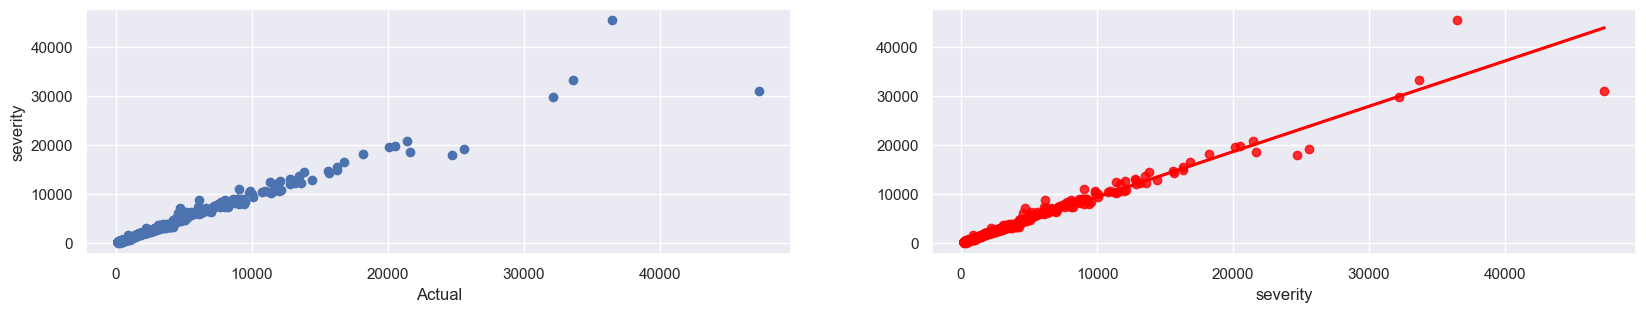

In [84]:
plt.subplot(221)
plt.scatter(y_test,predicted);

plt.xlabel('Actual');
plt.ylabel('severity');

plt.subplot(222)
sns.regplot(x=y_test,y=predicted,ci=None,color ='red');

In [85]:
model.feature_names_in_=x.columns
importance=pd.concat([pd.DataFrame(model.feature_names_in_,columns=["feature_names"]),
           pd.DataFrame(model.feature_importances_,columns=["feature_importances"])],axis=1)
importance           

,feature_names,feature_importances
0,veh_value,0.047445
1,exposure,0.031973
2,numclaims,0.000005
3,veh_body,0.000146
4,veh_age,0.000045
5,gender,0.003957
6,area,0.001555
7,agecat,0.000330
8,frequincy,0.191442
9,pure_premium,0.723102


In [86]:
PurePremiumImportanceTabel=importance.sort_values(by='feature_importances',ascending=False)
PurePremiumImportanceTabel.to_pickle("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/App/Feature_importance_Table/SeverityImportanceTabel.pkl")

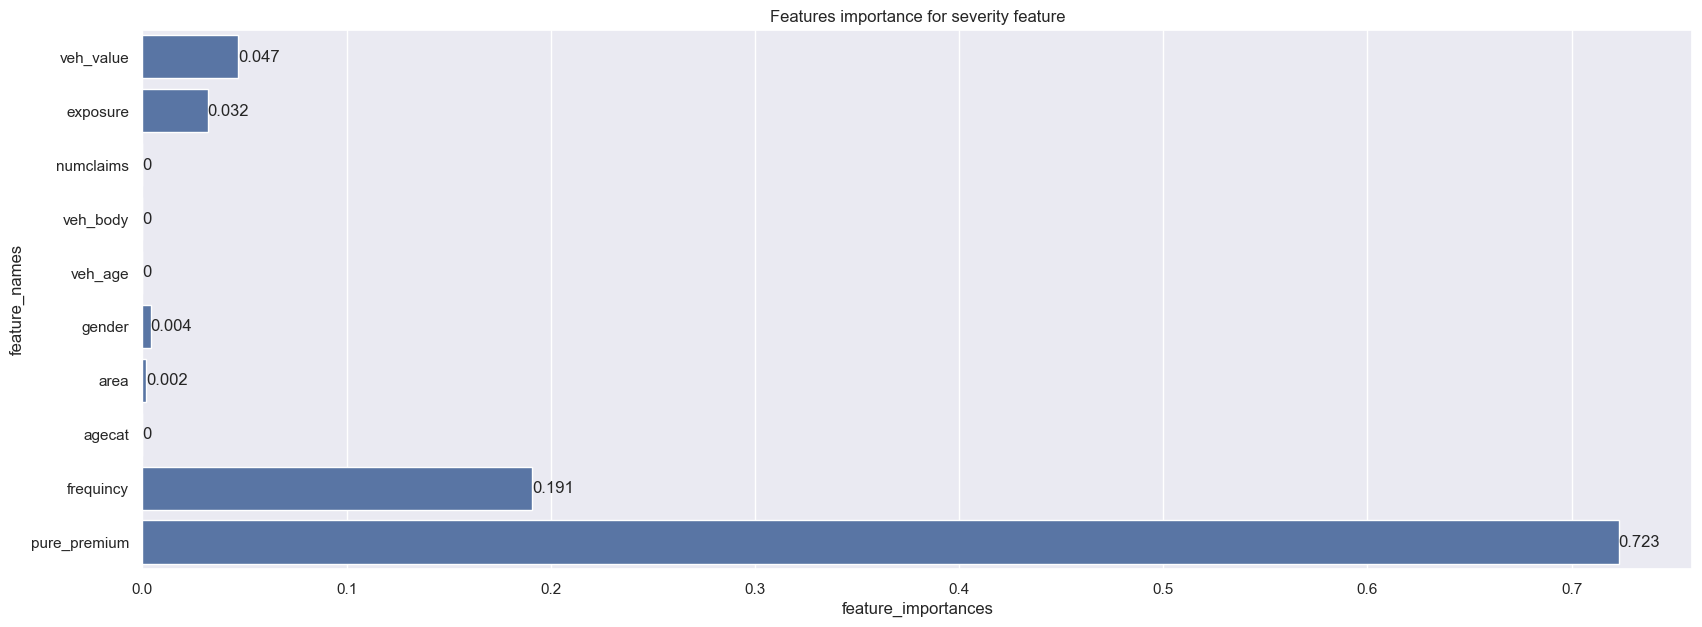

In [88]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for severity feature')
ax.bar_label(ax.containers[0]);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/App/Feature_importance_Graph/Severity_featureImportanc',dpi=500);

In [89]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/final_models/Severity_final_model.pkl","wb") as f:
    pickle.dump(model,f)

---